In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_scroll { height:35em !important; }</style>"))

In [143]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

In [144]:
?KMeans

In [3]:
from hsip.reader.reader import open_ENVI
from hsip.reader.reader import open_TIF
from hsip.processing import processing 
from hsip.clustering.clustering import CosClust, SCH, HDBSCAN

from hsip.rgb.labels import labels_to_rgb
from hsip.rgb.colors import colors_set
from hsip.rgb.rgb import hsi_synthesize_rgb
from hsip.rgb.rgb import simple_synthesize_rgb

from hsip.analysis.analysis import get_cross_correlation_matrix


from hsip.graphics.graphics import show_correlation_matrix

In [4]:
tif = 'C:/Users/konst/Documents/GitHub/Moffett-Field-labeling/data/IndianPine/19920612_AVIRIS_IndianPine_Site3.tif'
hsi = open_TIF(tif)
hsi = hsi.swapaxes(0, 2)
hsi.shape

(145, 145, 220)

100%|█████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 44148.46it/s]


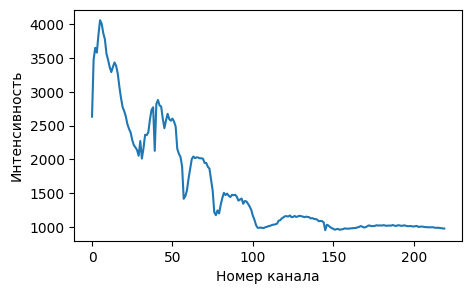

In [5]:
rayleigh_signature = processing.rayleigh_scattering(hsi, inplace=True)
plt.figure(figsize=(5, 3))
plt.plot(rayleigh_signature)
plt.xlabel('Номер канала')
plt.ylabel('Интенсивность')
plt.show()

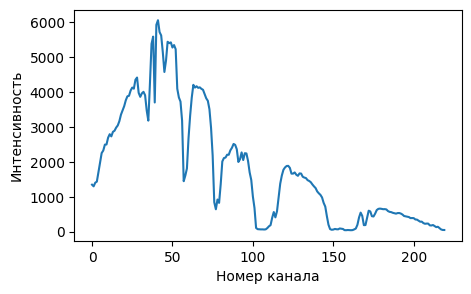

In [6]:
thresholds = np.zeros(shape=hsi.shape[2], dtype=float)
hsi = processing.sigma_maximum_filter(hsi, thresholds=thresholds)
plt.figure(figsize=(5, 3))
plt.plot(thresholds)
plt.xlabel('Номер канала')
plt.ylabel('Интенсивность')
plt.show()

In [183]:
from sklearn.cluster import KMeans as source_KMeans

Напиши документацию в стандарте numpy к этой функции на русском языке:

class KMeans():
    '''
    Класс KMeans

    Класс для кластеризации данных методом K-средних с возможностью задания начальных центроидов, настройки количества кластеров, выбора метрики и ограничения числа итераций.

    Атрибуты
    --------
    labels : np.ndarray
        Метки кластеров для каждого объекта в данных после выполнения алгоритма.
    centroids : np.ndarray
        2D массив формы `(n_clusters, n_features)`, содержащий центроиды кластеров.
    medoids : np.ndarray
        2D массив формы `(n_clusters, n_features)`, содержащий медианы кластеров.
    n_clusters : int
        Количество указанных кластеров.
    metric : str
        Метрика расстояния, используемая для расчёта расстояний. Доступные значения: `'euclidean'`, `'cosine'`.
    verbose : bool
        Флаг вывода прогресса выполнения алгоритма. По умолчанию `True`.
    max_iter : int
        Максимальное количество итераций алгоритма. По умолчанию `300`.

    Методы
    ------
    fit(source_data)
        Выполняет кластеризацию методом K-средних на входных данных.

    Параметры
    ---------
    centroids : list | np.ndarray, optional
        Начальные центроиды. Если не указаны, центроиды инициализируются случайным выбором из данных.
    n_clusters : int, optional
        Количество кластеров. Требуется, если не заданы центроиды.
    metric : str, optional
        Метрика для расчёта расстояний между точками и центроидами. Поддерживаются `'euclidean'` и `'cosine'`. По умолчанию `'euclidean'`.
    verbose : bool, optional
        Вывод информации о ходе выполнения. По умолчанию `True`.
    max_iter : int, optional
        Максимальное число итераций. По умолчанию `300`.

    Пример
    ------
    Кластеризация данных с 3 кластерами:
    
    >>> import numpy as np
    >>> data = np.random.rand(100, 2)  # Случайные точки
    >>> kmeans = KMeans(n_clusters=3)
    >>> labels = kmeans.fit(data)

    Задание начальных центроидов:
    
    >>> initial_centroids = [[0.1, 0.1], [0.5, 0.5], [0.9, 0.9]]
    >>> kmeans = KMeans(centroids=initial_centroids)
    >>> labels = kmeans.fit(data)

    Вывод центроидов:
    
    >>> print(kmeans.centroids)
    '''
    def __init__(self, centroids: list | np.ndarray = None, n_clusters: int = None, metric: str = 'euclidean', verbose: bool = True, max_iter: int = 300):
        np.random.seed(42)
        
        if centroids is None and n_clusters is None:
            raise ValueError('For KMeans you need to pass the number of clusters or the initial set of centroids.')
        
        self.labels = None
        self.verbose = verbose
            
        self.centroids = None
        self.medoids = None
        
        self.max_iter = max_iter
        
        if centroids is not None:
            if isinstance(centroids, list):
                self.centroids = np.array(centroids)
            else:
                self.centroids = centroids
            self.n_clusters = centroids.shape[0]
            
        else:
            self.n_clusters=n_clusters
            
        if metric not in ['euclidean', 'cosine']:
            raise ValueError('Available metrics: euclidean, cosine')
        self.metric = metric
            
    
    def fit(self, source_data: np.ndarray):
        if self.centroids is None:
            self.centroids = source_data[np.random.choice(range(len(source_data)), size=self.n_clusters, replace=False)]
            self.centroids = np.array(self.centroids)
    
        for i in tqdm(range(self.max_iter), disable=not self.verbose): 
            # Расчет расстояний между точками и центроидами
            distances = cdist(source_data, self.centroids, metric=self.metric)

            # Определение ближайшего центроида для каждой точки
            self.labels = np.argmin(distances, axis=1)

            # Обновление центроидов на основе средних значений в каждом кластере
            new_centroids = np.array([source_data[self.labels==clust].mean(axis=0) for clust in range(self.n_clusters)])

            # Проверка условия сходимости
            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids
            
            _, self.medoids = get_centroids_and_medoids(self.labels, source_data, metric)
        
        return self.labels

In [190]:
model = KMeans(centroids=flat_hsi[[1, 200, 534, 1234]])
labels = model.fit(flat_hsi)

 11%|████████▉                                                                        | 33/300 [00:00<00:04, 64.83it/s]


In [191]:
labels

array([1, 1, 1, ..., 3, 3, 3], dtype=int64)

In [ ]:
def clear_KMeans(imfs, HSI, number_of_clusters = 4, reference = None, max_iters = 50):
    
    HSI = np.reshape(HSI, (HSI.shape[0] * HSI.shape[1], HSI.shape[2]))
    
    height, width, bands = imfs.shape
    imfs = np.reshape(imfs, (height * width, bands))
    
    mask = np.arange(0, imfs.shape[0], dtype = int)
    bool_mask = np.all(HSI == -50, axis = 1)
    mask[bool_mask] = -1
    
    clear_imfs = imfs[mask != -1]
    clear_mask = mask[mask != -1]
    
    if reference is None:
        print("random centroids")
        kmeans = KMeans(n_clusters = number_of_clusters, random_state = 0, n_init = "auto").fit(clear_imfs)
    else:
        print("init centroids")
        kmeans = KMeans(n_clusters = reference.shape[0], init = reference, n_init = "auto").fit(clear_imfs)
    centers = kmeans.cluster_centers_
    clear_labels = kmeans.labels_
    
    #centers, clear_labels = do_kmeans(X = clear_imfs, K = reference.shape[0], init = reference, max_iters = max_iters)

    labels = np.zeros(shape = height * width, dtype = int)
    
    for i in range(clear_mask.shape[0]):
        labels[clear_mask[i]] = clear_labels[i] + 1
    
    labels = np.reshape(labels, (height, width))
    
    return centers, labels

In [141]:
from matplotlib import rcParams
from hsip.rgb.colors import Color

#Напиши документацию в стандарте numpy к этой функции на русском языке:

def show_curves(
    curves: np.ndarray,
    labels: list | np.ndarray = None,
    colors: list | np.ndarray = None,
    xlabel: str = 'Номер канала',
    ylabel: str = 'Величина',
    title: str = None,
    path: str = None, 
    scale_img: float = 4.0
):
    '''
    Отображение набора кривых с возможностью настройки меток, цветов и сохранения.

    Функция визуализирует набор кривых, где каждая строка массива `curves` соответствует одной кривой.
    Можно задавать метки для легенды, цвета кривых и параметры отображения.

    Параметры
    ----------
    curves : np.ndarray
        Двумерный массив размером `(n_curves, n_points)`, где каждая строка представляет одну кривую.
        Если передан одномерный массив, он автоматически преобразуется в массив с одной строкой.
    labels : list | np.ndarray, optional
        Метки для каждой кривой. Если не указаны (по умолчанию `None`), кривые будут отображены без легенды.
    colors : list | np.ndarray, optional
        Цвета для кривых. Если не указаны (по умолчанию `None`), используются заранее заданные цвета.
        Количество цветов должно совпадать с количеством кривых.
    xlabel : str, optional
        Метка оси X (по умолчанию `'Номер канала'`).
    ylabel : str, optional
        Метка оси Y (по умолчанию `'Величина'`).
    title : str, optional
        Заголовок графика (по умолчанию `None`).
    path : str, optional
        Путь для сохранения изображения. Если не указан (по умолчанию `None`), изображение отображается в окне.
    scale_img : float, optional
        Коэффициент масштабирования размера изображения (по умолчанию `4.0`).

    Возвращает
    ---------
    None

    Пример
    -------
    Отображение трёх кривых с разными метками и цветами:
    
    >>> import numpy as np
    >>> curves = np.random.rand(3, 100)
    >>> labels = ['Кривая 1', 'Кривая 2', 'Кривая 3']
    >>> colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    >>> show_curves(curves, labels=labels, colors=colors, title='Пример графика')

    Сохранение графика в файл:
    
    >>> show_curves(curves, path='curves_plot.png')
    '''
    
    if len(curves.shape) == 1:
        curves = curves[np.newaxis]
    
    if labels is not None:
        if isinstance(labels, str):
            labels = [labels]
        if isinstance(labels, list):
            labels = np.array(labels)
    
    dpi = rcParams['figure.dpi']
    fig_size = (160 / float(dpi)) * scale_img, (90 / float(dpi)) * scale_img
    
    if colors is None:
        colors = Color() # Заранее определённый набор цветов
    else:
        if isinstance(colors, list):
            colors = np.array(colors)
        if len(colors.shape) == 1:
            colors = colors[np.newaxis]
        if curves.shape[0] != colors.shape[0]:
            print(colors)
            raise ValueError('The number of curves and colors for them must match.')
    
    plt.figure(figsize=fig_size)
    for i in range(curves.shape[0]):
    
        if labels is None:
            plt.plot(curves[i], color=colors[i], lw=2)
        else:
            plt.plot(curves[i], color=colors[i], lw=2, label=labels[i])
        
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if labels is not None:
        plt.legend()
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path, dpi=dpi, bbox_inches='tight', pad_inches=0)
        plt.close()

def show_image(image: np.ndarray, path: str = None, color_bar: bool = False, scale_img: float = 1.0):
    '''
    Отображение изображения с возможностью сохранения и масштабирования.

    Функция визуализирует переданное изображение. Поддерживается отображение
    цветных RGB изображений и одноканальных изображений с настройкой цветовой шкалы.
    Также можно сохранить изображение в файл, указав путь в параметре `path`.

    Параметры
    ----------
    image : np.ndarray
        Массив изображения. Для RGB изображения тип данных должен быть `uint8`, 
        а размерность массива — `(height, width, 3)`. Для одноканального изображения
        допускаются другие типы данных и размерность `(height, width)`.
    path : str, optional
        Путь для сохранения изображения. Если не указан (по умолчанию `None`), 
        изображение будет отображено в окне.
    color_bar : bool, optional
        Если `True`, для одноканальных изображений добавляется цветовая шкала (по умолчанию `False`).
        Для RGB изображений этот параметр игнорируется.
    scale_img : float, optional
        Коэффициент масштабирования изображения. Например, при значении 2.0 изображение
        будет отображено в два раза крупнее (по умолчанию `1.0`).

    Возвращает
    ---------
    None

    Пример
    -------
    Отображение и сохранение RGB изображения:
    
    >>> import numpy as np
    >>> rgb_image = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
    >>> show_image(rgb_image, path='rgb_image.png', scale_img=1.5)

    Отображение одноканального изображения с цветовой шкалой:
    
    >>> grayscale_image = np.random.rand(100, 100)
    >>> show_image(grayscale_image, color_bar=True)
    '''
    
    dpi = rcParams['figure.dpi']
    height = image.shape[0]
    width = image.shape[1]
    fig_size = (width / float(dpi)) * scale_img, (height / float(dpi)) * scale_img
    
    if len(image.shape) == 3:
        color_bar = False
        if image.dtype != np.uint8:
            raise ValueError('For color RGB image the type should be uint8.')
        
    plt.figure(figsize=fig_size)
    plt.imshow(image)
    if color_bar:
        plt.colorbar(shrink=0.75)
    plt.axis('off')
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path, dpi=dpi, bbox_inches='tight', pad_inches=0)
        plt.close()

In [78]:
show_image(hsi[..., 93], path='test', color_bar=True, scale_img=5)

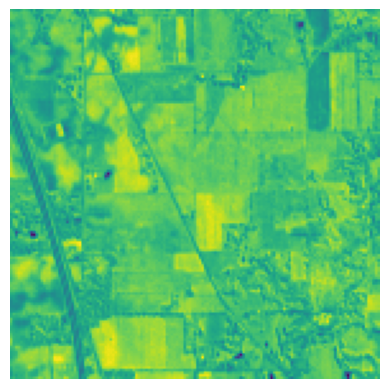

In [58]:
plt.figure()
plt.imshow(hsi[..., 93])
plt.axis('off')
plt.show()

In [186]:
flat_hsi = np.reshape(hsi, (hsi.shape[0] * hsi.shape[1], hsi.shape[2]))

model = CosClust(0.975)
labels = model.fit(flat_hsi)

print(f'Всего классов: {len(np.unique(labels))}')
print(model.centroids.shape)
print(model.medoids.shape)

CosClust take a step 1/2


100%|████████████████████████████████████████████████████████████████████████| 21025/21025 [00:00<00:00, 405678.81it/s]


CosClust take a step 2/2


100%|████████████████████████████████████████████████████████████████████████| 21025/21025 [00:00<00:00, 118512.62it/s]

Всего классов: 11
(11, 220)
(11, 220)


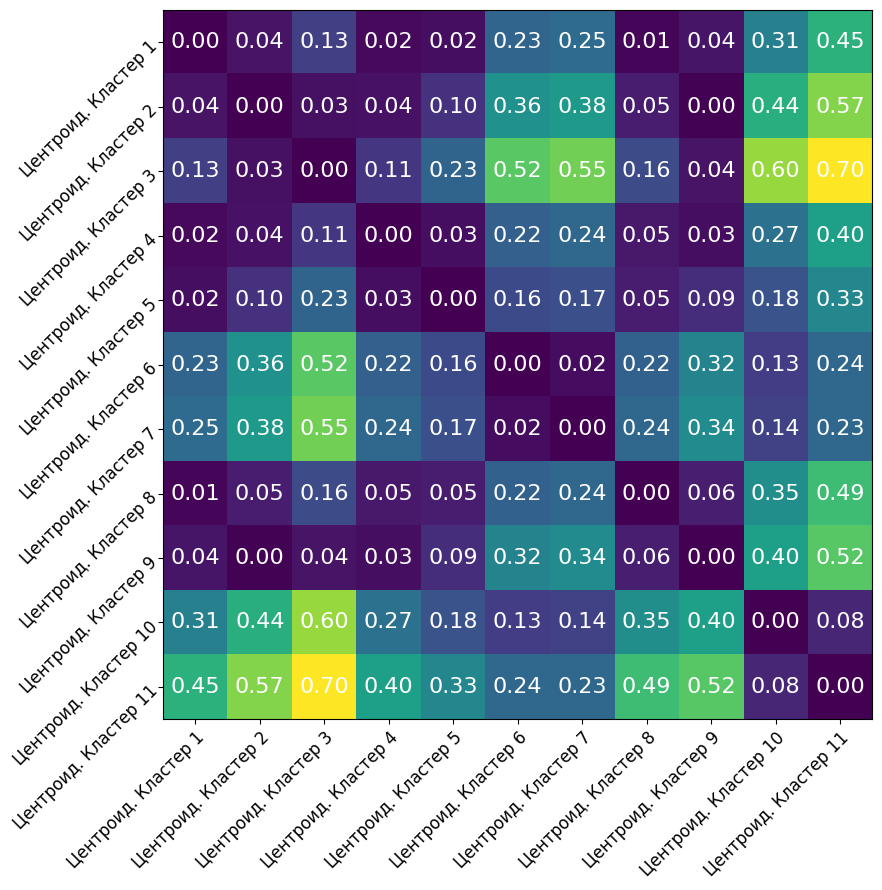

In [10]:
cross_corr_mat = get_cross_correlation_matrix(model.centroids, metric='cosine')
show_correlation_matrix(cross_corr_mat, [f'Центроид. Кластер {i+1}' for i in range(cross_corr_mat.shape[0])])

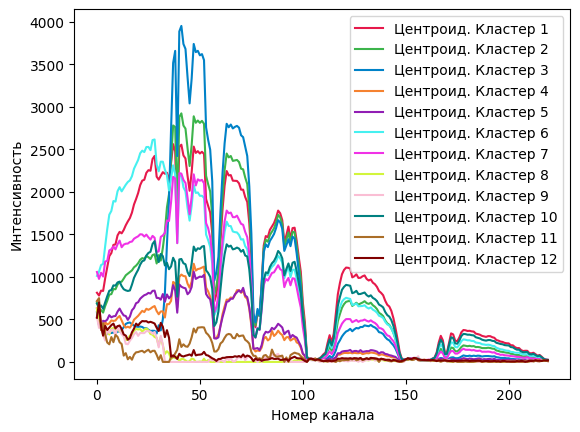

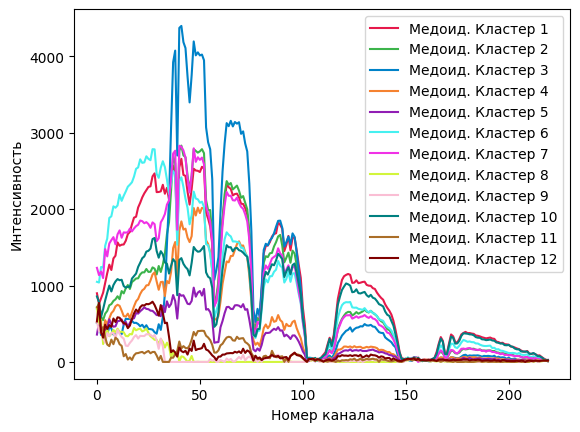

In [62]:
plt.figure()
for i, sig in enumerate(model.centroids):
    plt.plot(sig, label=f'Центроид. Кластер {i+1}', color=colors_set[i])
    plt.xlabel('Номер канала')
    plt.ylabel('Интенсивность')
plt.legend()
plt.show()

plt.figure()
for i, sig in enumerate(model.medoids):
    plt.plot(sig, label=f'Медоид. Кластер {i+1}', color=colors_set[i])
    plt.xlabel('Номер канала')
    plt.ylabel('Интенсивность')
plt.legend()
plt.show()

In [63]:
labels = np.reshape(labels, (hsi.shape[0], hsi.shape[1]))

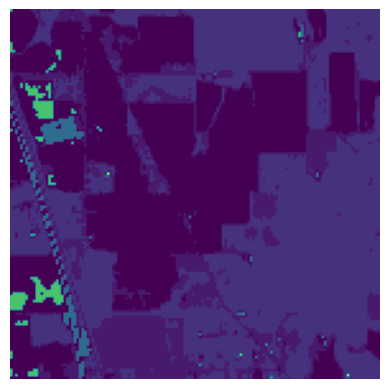

In [64]:
plt.figure()
plt.imshow(labels)
plt.axis('off')
plt.show()

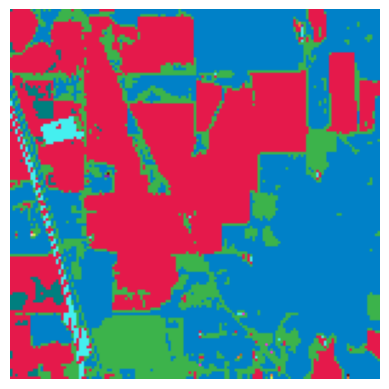

In [65]:
color_labels = labels_to_rgb(labels)
plt.figure()
plt.imshow(color_labels)
plt.axis('off')
plt.show()

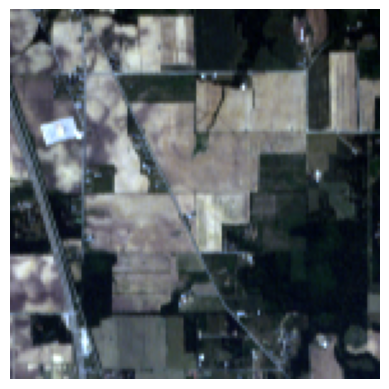

In [66]:
rgb_image = hsi_synthesize_rgb(hsi, [29, 19, 9])
plt.figure()
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

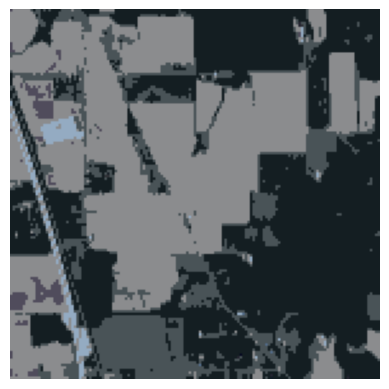

In [67]:
rgb_labels = labels_to_rgb(labels, rgb_image)
plt.figure()
plt.imshow(rgb_labels)
plt.axis('off')
plt.show()

--------------------

In [86]:
model1 = SCH(fcluster_t=1.0-0.92)
labels1 = model1.fit(flat_hsi)

print(f'Всего классов: {len(np.unique(labels1))}')
print(model1.centroids.shape)
print(model1.medoids.shape)

Всего классов: 10
(10, 220)
(10, 220)


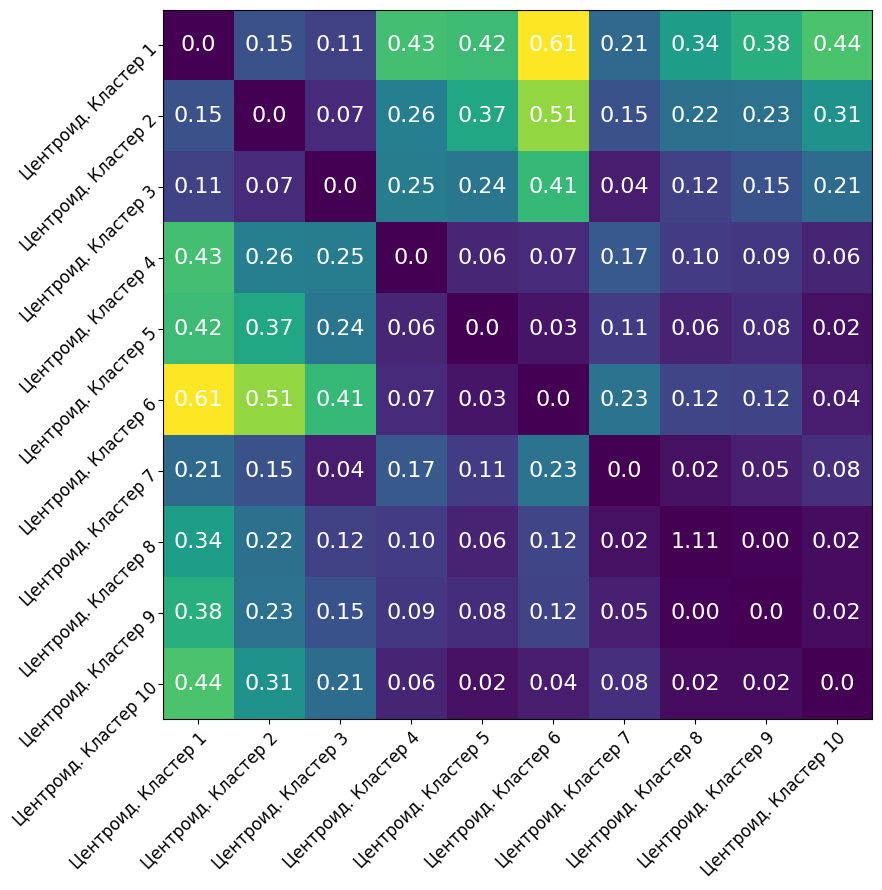

In [87]:
cross_corr_mat = get_cross_correlation_matrix(model1.centroids, metric='cosine')
show_corr_matrix(cross_corr_mat, [f'Центроид. Кластер {i+1}' for i in range(cross_corr_mat.shape[0])], 'asdas')

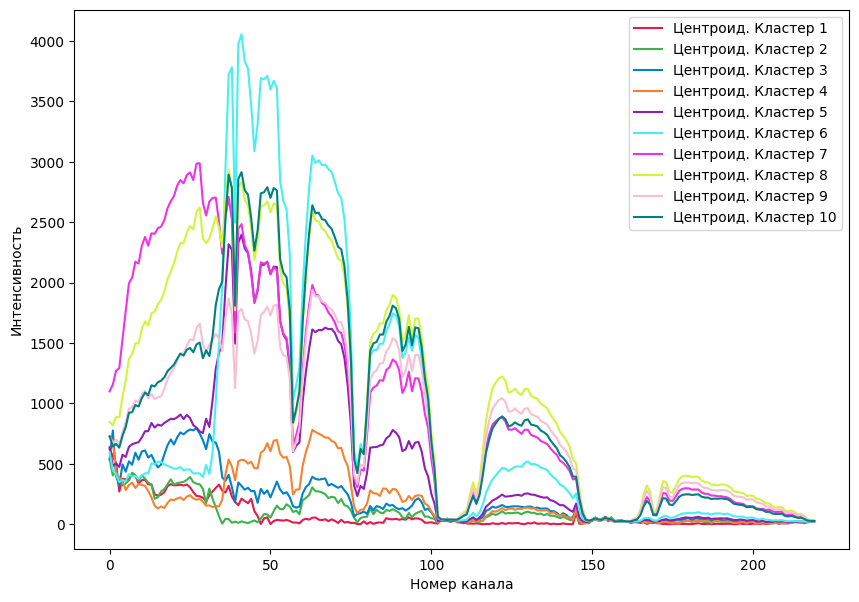

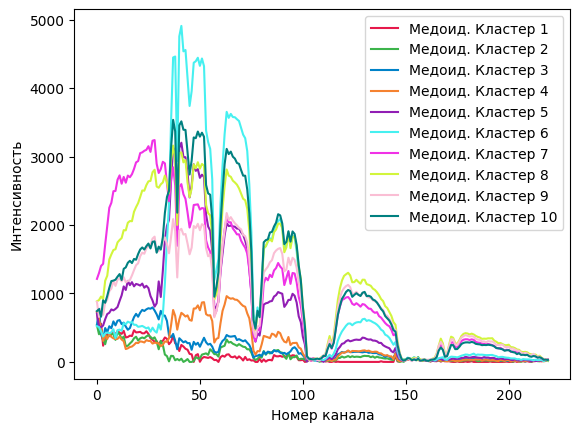

In [132]:
plt.figure(figsize=(10, 7))
for i, sig in enumerate(model1.centroids):
    plt.plot(sig, label=f'Центроид. Кластер {i+1}', color=colors_set[i])
    plt.xlabel('Номер канала')
    plt.ylabel('Интенсивность')
plt.legend()
plt.show()

plt.figure()
for i, sig in enumerate(model1.medoids):
    plt.plot(sig, label=f'Медоид. Кластер {i+1}', color=colors_set[i])
    plt.xlabel('Номер канала')
    plt.ylabel('Интенсивность')
plt.legend()
plt.show()

In [89]:
labels1 = np.reshape(labels1, (hsi.shape[0], hsi.shape[1]))

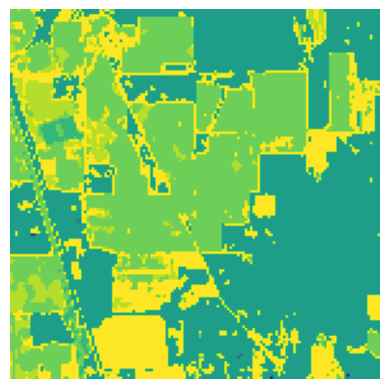

In [90]:
plt.figure()
plt.imshow(labels1)
plt.axis('off')
plt.show()

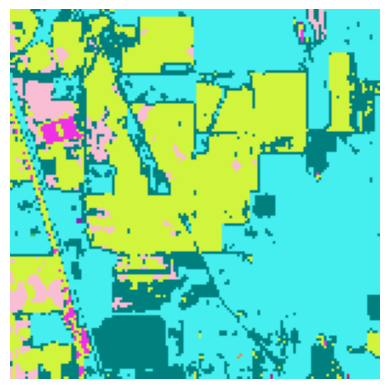

In [91]:
color_labels1 = labels_to_rgb(labels1)
plt.figure()
plt.imshow(color_labels1)
plt.axis('off')
plt.show()

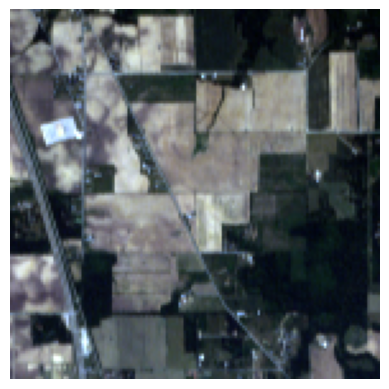

In [92]:
rgb_image1 = hsi_synthesize_rgb(hsi, [29, 19, 9])
plt.figure()
plt.imshow(rgb_image1)
plt.axis('off')
plt.show()

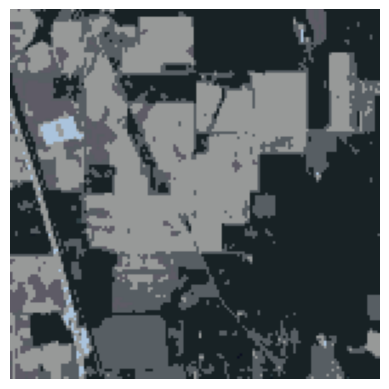

In [93]:
rgb_labels1 = labels_to_rgb(labels1, rgb_image1)
plt.figure()
plt.imshow(rgb_labels1)
plt.axis('off')
plt.show()

In [131]:
?labels_to_rgb

----------------------

In [94]:
model2 = HDBSCAN(min_cluster_size=10, min_samples=10, cluster_selection_epsilon=0.0)
labels2 = model2.fit(flat_hsi)

print(f'Всего классов: {len(np.unique(labels2))}')
print(model2.centroids.shape)
print(model2.medoids.shape)

Всего классов: 3
(3, 220)
(3, 220)


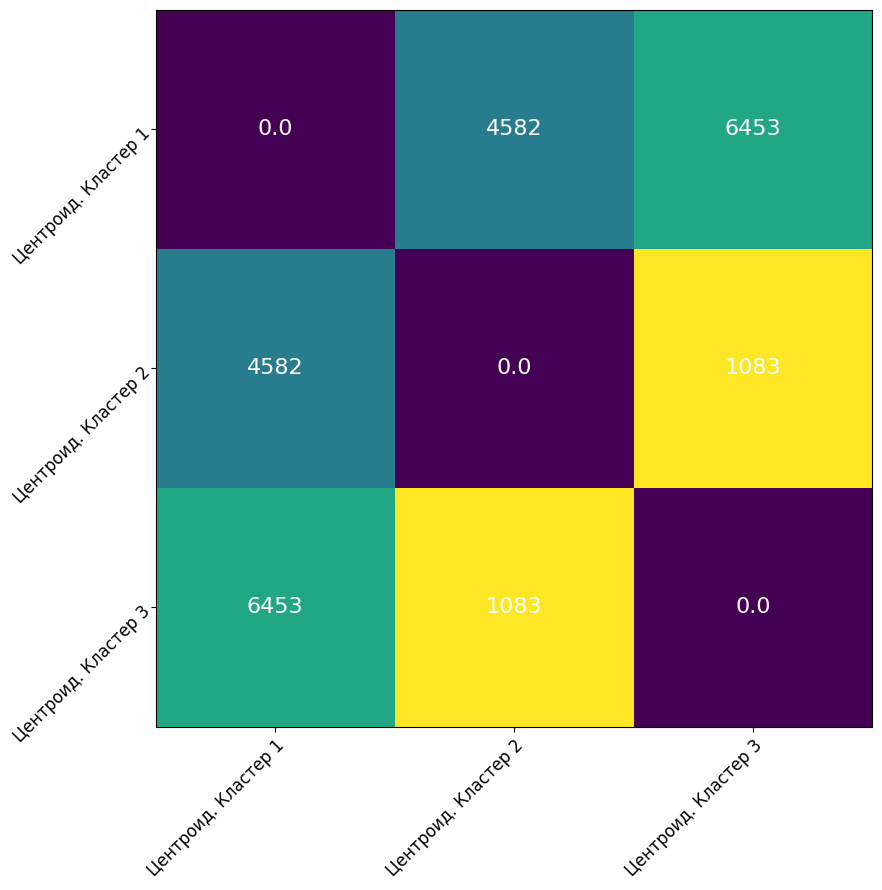

In [107]:
cross_corr_mat = get_cross_correlation_matrix(model2.centroids, metric='euclidean')
show_corr_matrix(cross_corr_mat, [f'Центроид. Кластер {i+1}' for i in range(cross_corr_mat.shape[0])], 'asdas')

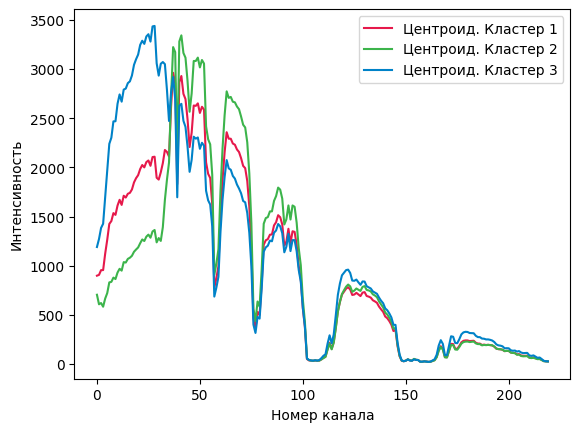

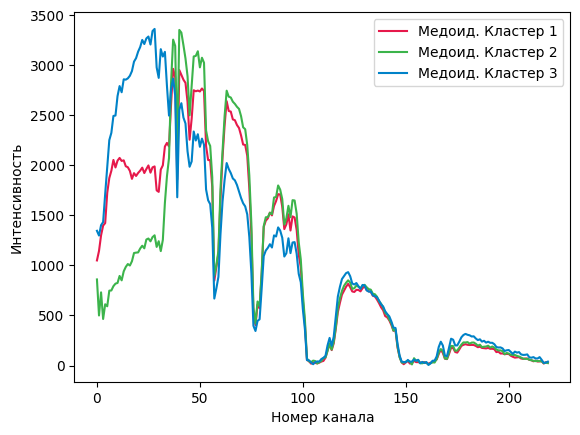

In [96]:
plt.figure()
for i, sig in enumerate(model2.centroids):
    plt.plot(sig, label=f'Центроид. Кластер {i+1}', color=colors_set[i])
    plt.xlabel('Номер канала')
    plt.ylabel('Интенсивность')
plt.legend()
plt.show()

plt.figure()
for i, sig in enumerate(model2.medoids):
    plt.plot(sig, label=f'Медоид. Кластер {i+1}', color=colors_set[i])
    plt.xlabel('Номер канала')
    plt.ylabel('Интенсивность')
plt.legend()
plt.show()

In [97]:
labels2 = np.reshape(labels2, (hsi.shape[0], hsi.shape[1]))

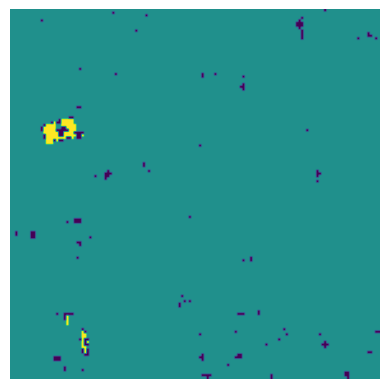

In [98]:
plt.figure()
plt.imshow(labels2)
plt.axis('off')
plt.show()

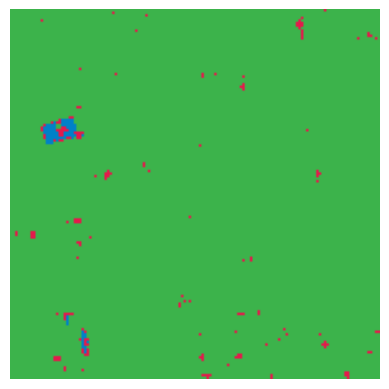

In [99]:
color_labels2 = labels_to_rgb(labels2)
plt.figure()
plt.imshow(color_labels2)
plt.axis('off')
plt.show()

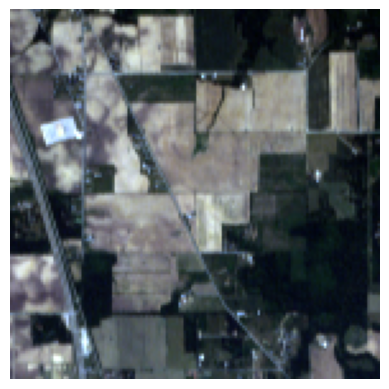

In [100]:
rgb_image2 = hsi_synthesize_rgb(hsi, [29, 19, 9])
plt.figure()
plt.imshow(rgb_image2)
plt.axis('off')
plt.show()

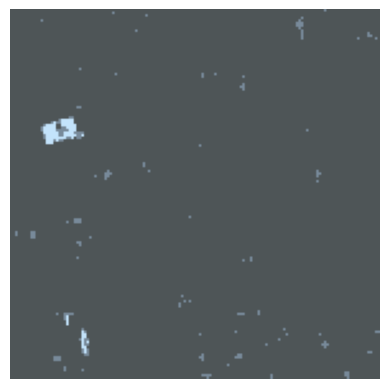

In [101]:
rgb_labels2 = labels_to_rgb(labels2, rgb_image2)
plt.figure()
plt.imshow(rgb_labels2)
plt.axis('off')
plt.show()

-----------------------

In [102]:
from hsip.swemd.swemd import SWEMD

In [103]:
IMFs, windows = SWEMD(hsi, number_of_modes=12, windows_size=3)

100%|██████████████████████████████████████████████████████████████████████████| 21025/21025 [00:04<00:00, 4221.05it/s]


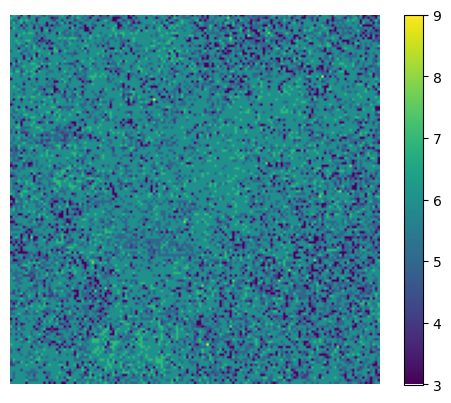

In [104]:
plt.figure()
plt.imshow(windows[6])
plt.colorbar()
plt.axis('off')
plt.show()

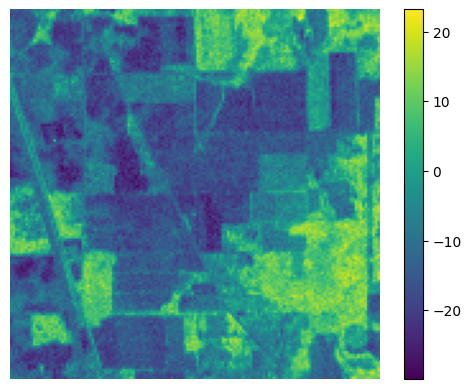

In [130]:
plt.figure()
plt.imshow(IMFs[3, :, :, 39])
plt.colorbar()
plt.axis('off')
plt.show()

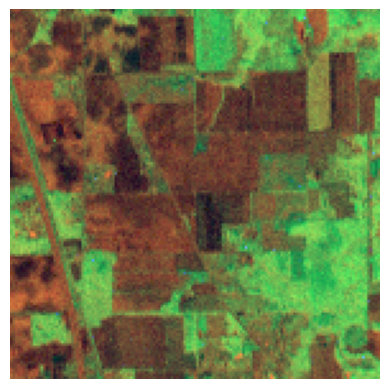

In [129]:
rgb_IMFs = simple_synthesize_rgb(IMFs[[2, 3, 4], :, :, 39])
plt.figure()
plt.imshow(rgb_IMFs)
plt.axis('off')
plt.show()

In [1]:
def show_corr_matrix(corr_matrix, label_axis, title, path = None, m = 'a'):    
    fig, ax = plt.subplots(figsize = (9, 9))
    im = ax.imshow(corr_matrix)

    ax.set_xticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)
    ax.set_yticks(np.arange(len(label_axis)), labels=label_axis, fontsize = 12)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    for i in range(len(label_axis)):
        for j in range(len(label_axis)):
            if m == 'e':
                text = ax.text(j, i, int(corr_matrix[i, j]), ha="center", va="center", color="w", fontsize = 16)
            elif m == 'a':       
                text = ax.text(j, i, str(corr_matrix[i, j])[0:4], ha="center", va="center", color="w", fontsize = 16)
    
    fig.tight_layout()
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

In [ ]:
show_correlation_matrix